In [1]:
import os
import cv2
import numpy as np
from collections import defaultdict, namedtuple
import matplotlib.pyplot as plt
import matplotlib

In [2]:
"""
Common Functions
You are not expected to modify these
"""
_bits = []
for i in range(256):
    bs = bin(i)[2:].rjust(8,'0')
    _bits.append(np.array([float(v) for v in bs]))

def read_img(path):
    """Read image."""
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    return image

def save_img(img, path):
    """Save image."""
    cv2.imwrite(path, img)

# note this is different than in previous homeworks
def show_img(image, *args, **kwargs):
    if len(image.shape) == 2:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    plt.show()

def homography_transform(X, H):
    '''
    Perform homography transformation on a set of points X
    using homography matrix H

    Input - X: a set of 2D points in an array with size (N,2)
            H: a 3*3 homography matrix
    Output -Y: a set of 2D points in an array with size (N,2)
    '''
    X_homogeneous = np.hstack([X,np.ones((X.shape[0],1))])
    Y = np.dot(H,X_homogeneous.T).T
    return Y[:,:2] / Y[:,2][:,None]

def get_match_points(kp1, kp2, matches):
    '''
    Returns list of paired keypoint locations

    Input - kp1: Keypoint matrix 1 of shape (N,4)
            kp2: Keypoint matrix 1 of shape (M,4)
            matches: List of matching pairs indices between the 2 sets of keypoints (K,2)

    Output - An array of shape (K,4) where row i contains pixel locations corresponding
             to a matched keypoint in the 2 images : [img1_x, img1_y, img2_x, img2_y]
    '''
    return np.hstack([kp1[matches[:,0],:2], kp2[matches[:,1],:2]])

def kps_to_matrix(kps):
    '''
    Converts cv2 container of keypoint locations into numpy array

    Input - kps: opencv container of keypoints location

    Output - K: A numpy Keypoint matrix of shape (N,4)
    '''
    K = np.zeros((len(kps),4))
    for i in range(len(kps)):
        K[i,:2] = kps[i].pt
        K[i,2] = kps[i].angle
        K[i,3] = kps[i].octave
    return K

def expand_binarize(desc):
    '''
    Explicitly expand packed binary keypoint descriptors like AKAZE and ORB.
    You do not need to modify or worry about this.

    AKAZE and ORB return a descriptor that is binary. Usually one compares
    descriptors using the hamming distance (# of bits that differ). This is
    usually fast since one can do this with binary operators. On Intel
    processors, there's an instruction for this: popcnt/population count.

    On the other hand, this prevents you from actually implementing all the steps
    of the pipeline and requires you writing a hamming distance. So instead, we
    explicitly expand the feature from F packed binary uint8s to (8F) explicit
    binary 0 or 1 descriptors. The square of the L2 distance of these
    descriptors is the hamming distance.

    Converts a matrix where each row is a vector containing F uint8s into their
    explicit binary form.

    Input - desc: matrix of size (N,F) containing N 8F dimensional binary
                  descriptors packed into N, F dimensional uint8s

    Output - binary_desc: matrix of size (N,8F) containing only 0s or 1s that
                          expands this to be explicit
    '''
    N, F = desc.shape
    binary_desc = np.zeros((N,F*8))
    for i in range(N):
        for j in range(F):
            binary_desc[i,(j*8):((j+1)*8)] = _bits[desc[i,j]]
    return binary_desc

def get_AKAZE(I):
    '''
    Extracts AKAZE keypoints and descriptors from an image

    Input - img: Input image of shape (H,W,3)

    Output - kps: (K,4) matrix where each row is [x,y,angle,octave]
             desc: (K,1024) matrix of AKAZE descriptors expanded to be
                   comparable using squared L2 distance
    '''
    akaze = cv2.AKAZE_create()
    kps, D = akaze.detectAndCompute(I, None)
    return kps_to_matrix(kps), expand_binarize(D).astype(np.float32)


def visualize_keypoints(I1, I2, kps1, kps2):
    '''
    Visualize keypoints between the two input images

    Input - I1: Input image 1 of shape (H1,W1,3)
    Input - I1: Input image 1 of shape (H1,W1,3)
    Input - kps1: (K,4) matrix where each row is [x,y,angle,octave]
    Input - kps2: (K,4) matrix where each row is [x,y,angle,octave]
    '''
    gap = 100
    concat_image = np.hstack((I1, np.zeros((I1.shape[0], gap, I1.shape[-1]), dtype=np.uint8), I2))
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title('Keypoints')
    ax.imshow(concat_image)

    kps2[:,0] = kps2[:,0] + I1.shape[1] + gap
    merged_kps = np.vstack((kps1, kps2))
    octaves = np.unique(merged_kps[:,3])
    octave_colors = ['r', 'b', 'g', 'y', 'w', 'c', 'm']
    octave_markers = ['o', 'x', '+', '*']
    octave_marker_size = [60, 40, 20, 10]
    for idx, o in enumerate(octaves):
        merged_kps_o = merged_kps[merged_kps[:,3]==o]
        ax.scatter(merged_kps[:,0], merged_kps[:,1],
                   c=octave_colors[idx],
                   marker=octave_markers[idx],
                   s=octave_marker_size[idx]
        )

    ax.axis('off')
    plt.show()

In [3]:
"""
Homography fitting functions
You should write these
"""

def fit_homography(XY):
    '''
    Given a set of N correspondences XY of the form [x,y,x',y'],
    fit a homography from [x,y,1] to [x',y',1].

    Input - XY: an array with size(N,4), each row contains two
            points in the form [x_i, y_i, x'_i, y'_i] (1,4)
    Output -H: a (3,3) homography matrix that (if the correspondences can be
            described by a homography) satisfies [x',y',1]^T === H [x,y,1]^T

    '''
    # write cross product trick
    equations = []

    for i in range(XY.shape[0]):
        x, y = XY[i, 0], XY[i, 1]         # Original points
        x_dash, y_dash = XY[i, 2], XY[i, 3] # Transformed points

        # First row for the cross-product equation
        equations.append([0, 0, 0, -x, -y, -1, y_dash * x, y_dash * y, y_dash])

        # Second row for the cross-product equation
        equations.append([x, y, 1, 0, 0, 0, -x_dash * x, -x_dash * y, -x_dash])
    A = np.vstack(equations)
    U,S,V = np.linalg.svd(A)
    H = V[-1,:].reshape(3,3)
    H = H/H[2,2]

    return H


def RANSAC_fit_homography(XY, eps=1, nIters=1000):
    '''
    Perform RANSAC to find the homography transformation
    matrix which has the most inliers

    Input - XY: an array with size(N,4), each row contains two
            points in the form [x_i, y_i, x'_i, y'_i] (1,4)
            eps: threshold distance for inlier calculation
            nIters: number of iteration for running RANSAC
    Output - bestH: a (3,3) homography matrix fit to the
                    inliers from the best model.

    Hints:
    a) Sample without replacement. Otherwise you risk picking a set of points
       that have a duplicate.
    b) *Re-fit* the homography after you have found the best inliers
    '''
    bestH, bestCount, bestInliers = np.eye(3), -1, np.zeros((XY.shape[0],))
    bestRefit = np.eye(3)

    rng = np.random.default_rng(seed=42)
    # iterate
    for i in range(nIters):
      # select small smaple of 8 points
      random_sample_idx = rng.choice(XY.shape[0], 9, replace=False)

      # fit homography
      H = fit_homography(XY[random_sample_idx])

      # compute errors
      h_p = homography_transform(XY[:, :2], H)
      error = np.linalg.norm(h_p - XY[:, 2:], axis=1)
      inliers_idx = np.where(error < eps)[0]
      inliers = XY[inliers_idx]
      # count inliers
      if len(inliers) > bestCount:
        # compute homography on inliers
        # save best model if inliners is best yet.
        bestH = H
        bestCount = len(inliers)
        bestInliers = np.array(inliers)
        bestRefit = fit_homography(bestInliers)
    print("Best Count: {}".format(bestCount))
    return bestRefit

points_case_1.npy


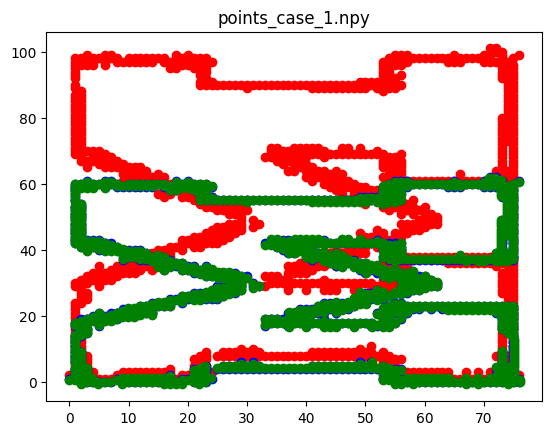

0.2500185423031464
[[ 1.00555949e+00  1.61370672e-03 -1.35143989e-01]
 [ 2.56045861e-03  6.22536404e-01 -7.35872070e-01]
 [ 4.51704286e-05  3.59823762e-05  1.00000000e+00]]
points_case_2.npy


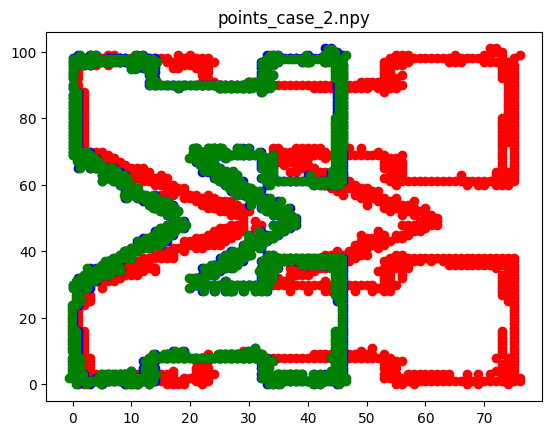

0.2412633623927551
[[ 6.20394776e-01  1.50050345e-03 -6.60977645e-01]
 [ 4.62565656e-05  1.00232229e+00 -4.06369835e-02]
 [ 3.66035139e-07  2.25931463e-05  1.00000000e+00]]
points_case_3.npy


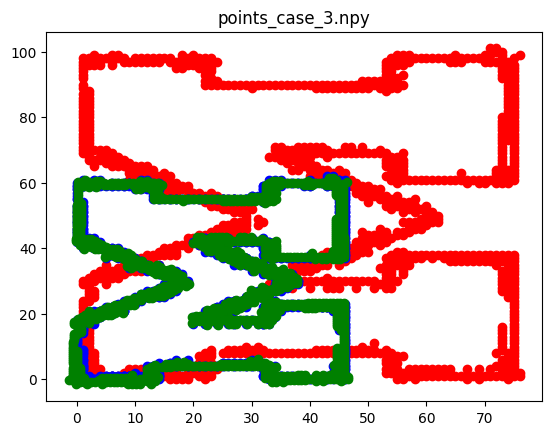

0.47034160903068517
[[ 6.46216419e-01  1.01850154e-02 -1.45233663e+00]
 [ 1.39156925e-02  6.46332905e-01 -1.60285342e+00]
 [ 3.11050183e-04  2.76954685e-04  1.00000000e+00]]
points_case_4.npy


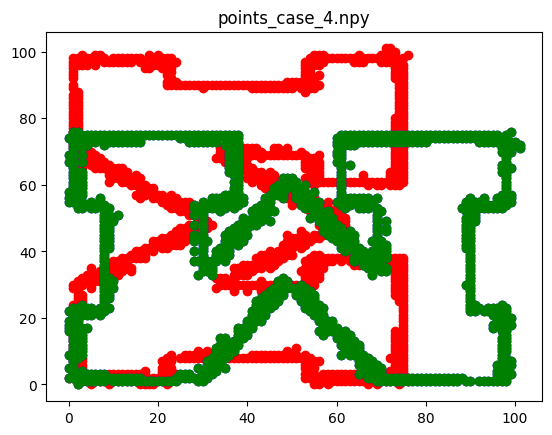

1.4815382810333453e-12
[[ 2.37073262e-14  1.00000000e+00 -1.98528855e-13]
 [ 1.00000000e+00 -1.69929680e-15 -9.31858251e-15]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]]
points_case_5.npy


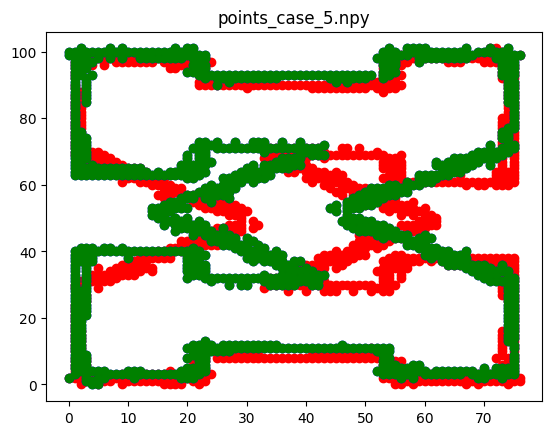

8.339543891421648e-12
[[-1.00000000e+00 -9.30268902e-14  7.60000000e+01]
 [-2.17535588e-13 -1.00000000e+00  1.01000000e+02]
 [ 5.03681505e-16 -2.10381254e-15  1.00000000e+00]]
points_case_6.npy


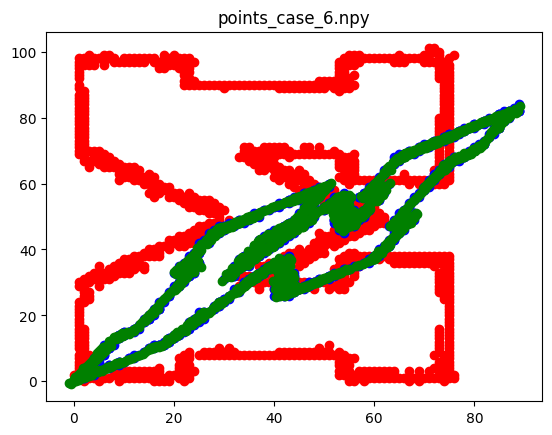

0.45956963413345847
[[ 4.01387046e-01  6.36777993e-01 -1.79445757e+00]
 [ 6.40534201e-01  3.96745666e-01 -1.76059696e+00]
 [ 2.21034153e-04  1.39932850e-04  1.00000000e+00]]
points_case_7.npy


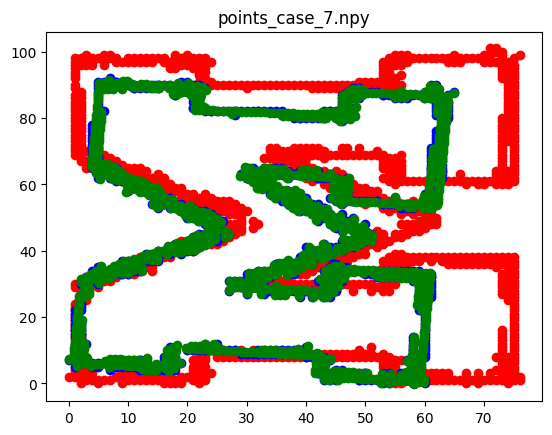

0.39183635536146827
[[ 7.70056604e-01  4.54255201e-02 -6.34808816e-02]
 [-7.87253712e-02  8.63813194e-01  5.49671671e+00]
 [-3.05270237e-04 -6.37121535e-05  1.00000000e+00]]
points_case_8.npy


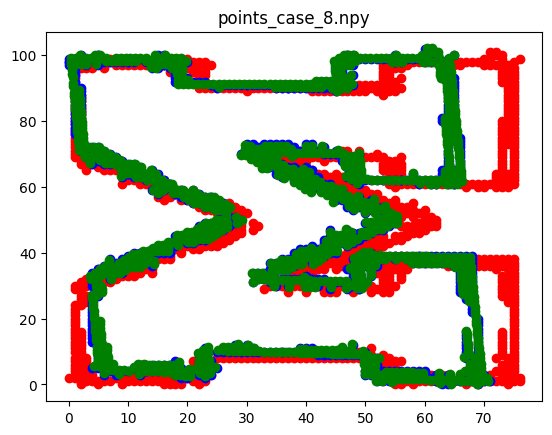

0.3912740261494523
[[ 8.41165566e-01 -4.86333708e-02  4.30457199e+00]
 [-4.77384685e-02  9.86999947e-01  3.56055033e+00]
 [-4.55556648e-04  1.08171485e-04  1.00000000e+00]]
points_case_9.npy


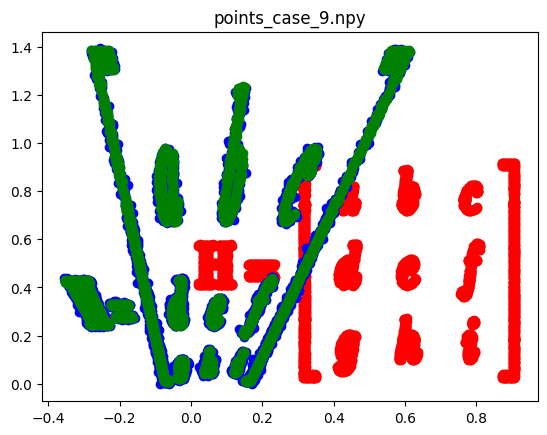

0.006315605468669031
[[ 3.99477222e-01 -3.67022614e-04 -1.99512262e-01]
 [-3.93211955e-04  3.99757796e-01  1.25766711e-04]
 [-6.59363495e-04 -8.00095366e-01  1.00000000e+00]]


In [4]:
# Homography Fitting script

rootpath = "hdata"
dir = os.listdir(rootpath)
# alphabetize
dir.sort()

# use for file in dir[2] to work on the third file only
for file in dir:
  # 1. load points X from homography_data
  print(file)
  points = np.load(file=os.path.join(rootpath,file))
  p1, p2 = points[:,:2], points[:,2:]

  # 2. fit a homography
  H = fit_homography(points)

  # 3. transform points
  p1_transformed = homography_transform(p1, H)

  # 4. plot the original points and transformed points
  plt.scatter(p1[:,0],p1[:,1],c='r',marker='o')
  plt.scatter(p2[:,0],p2[:,1],c='b',marker='o')
  plt.scatter(p1_transformed[:,0],p1_transformed[:,1],c='g',marker='o')
  plt.title(file)
  plt.show()

  # 5. compute average residual (pixel error per point)
  error = np.linalg.norm(p1_transformed - p2, axis=1).mean()
  print(error)
  print(H)




In [5]:
Matches = namedtuple('Matches', ['idx', 'idy', 'distance'])

"""
Image Stitching Functions
"""
def bilinear(image, row, col):
    """
    Return the interpolated value for row, col in image.
    Do not assume rol, col are in bounds.
    They must be non-negative and less than the width and height of image -1

    Input- image: H x W
    row, col: floating point scalar
    Output - value: scalar
    """
    top, left = int(row), int(col)
    if top >= image.shape[0] - 1 or left >= image.shape[1] - 1:
      return 0
    if row < 0 or col < 0:
      return 0

    bottom, right = top + 1, left + 1
    delta_row, delta_col = row - top, col - left

    value = (1 - delta_row) * (1 - delta_col) * image[top, left] + \
            (1 - delta_row) * delta_col * image[top, right] + \
            delta_row * (1 - delta_col) * image[bottom, left] + \
            delta_row * delta_col * image[bottom, right]

    return value


def compute_distance(desc1, desc2):
    '''
    Calculates L2 distance between 2 binary descriptor vectors.

    Input - desc1: Descriptor vector of shape (N,F)
            desc2: Descriptor vector of shape (M,F)

    Output - dist: a (N,M) L2 distance matrix where dist(i,j)
             is the squared Euclidean distance between row i of
             desc1 and desc2. You may want to use the distance
             calculation trick
             ||x - y||^2 = ||x||^2 + ||y||^2 - 2x^T y
    '''
    dist = None
    N, M = desc1.shape[0], desc2.shape[0]

    # compute squared norms
    sq_1, sq_2 = np.linalg.norm(desc1, axis=1)**2, np.linalg.norm(desc2, axis=1)**2
    sq_1, sq_2 = sq_1.reshape(N, -1), sq_2.reshape(-1, M)

    # dist(N, M) = (N, 1) - 2 * (N, M) + (1, M)
    dist = sq_1 - 2 * (desc1 @ desc2.T) + sq_2

    return dist

def find_matches(desc1, desc2, ratioThreshold):
    '''
    Calculates the matches between the two sets of keypoint
    descriptors based on distance and ratio test.

    Input - desc1: Descriptor vector of shape (N,F)
            desc2: Descriptor vector of shape (M,F)
            ratioThreshhold : maximum acceptable distance ratio between 2
                              nearest matches

    Output - matches: a list of indices (i,j) 1 <= i <= N, 1 <= j <= M giving
             the matches between desc1 and desc2.

             This should be of size (K,2) where K is the number of
             matches and the row [ii,jj] should appear if desc1[ii,:] and
             desc2[jj,:] match.
    '''
    matches = []

    # compute distance
    dist = compute_distance(desc1, desc2)
    N, M = dist.shape

    # find the smallest two difference in distances.
    nearest_neighbours = defaultdict(list)
    for i in range(N):
      min_dist = [Matches(-1, -1, float('inf')), Matches(-1, -1, float('inf'))]
      for j in range(M):
        if dist[i, j] < min_dist[0].distance:
          min_dist[0], min_dist[1] = Matches(i, j, dist[i, j]), min_dist[0]
        elif dist[i, j] < min_dist[1].distance:
          min_dist[1] = Matches(i, j, dist[i, j])
      nearest_neighbours[(min_dist[0].idx, min_dist[0].idy)].append(min_dist)

    # make sure that these are also the smallest differences column wise
    for j in range(M):
      min_dist = [Matches(-1, -1, float('inf')), Matches(-1, -1, float('inf'))]
      for i in range(N):
        if dist[i, j] < min_dist[0].distance:
          min_dist[0], min_dist[1] = Matches(i, j, dist[i, j]), min_dist[0]
        elif dist[i, j] < min_dist[1].distance:
          min_dist[1] = Matches(i, j, dist[i, j])
      nearest_neighbours[(min_dist[0].idx, min_dist[0].idy)].append(min_dist)

    # compute ratio
    for m in nearest_neighbours.values():
      # if match not detected in rows and columns, skip this point
      if len(m) < 2:
        continue
      mr, mc = m
      # decide if match based on distance ratio test
      if (mr[0].distance / mr[1].distance < ratioThreshold) and (mc[0].distance / mc[1].distance < ratioThreshold):
        matches.append([mr[0].idx, mr[0].idy])

    return matches

def draw_matches(img1, img2, kp1, kp2, matches):
    '''
    Creates an output image where the two source images stacked vertically
    connecting matching keypoints with a line.

    Input - img1: Input image 1 of shape (H1,W1,3)
            img2: Input image 2 of shape (H2,W2,3)
            kp1: Keypoint matrix for image 1 of shape (N,4)
            kp2: Keypoint matrix for image 2 of shape (M,4)
            matches: List of matching pairs indices between the 2 sets of
                     keypoints (K,2)

    Output - Image where 2 input images stacked vertically with lines joining
             the matched keypoints
    Hints!!:
    1) see cv2.line
    2) Use get_match_points() from the common functions box above
    to extract keypoint locations
    3) RGB values can be integers between 0 and 255 or floats between 0 and 1
    (floats between 0 and 255 don't work)
    '''
    output = None

    gap = 100
    concat_image = np.hstack((img1, np.zeros((img1.shape[0], gap, img1.shape[-1]), dtype=np.uint8), img2))
    kp2[:,0] = kp2[:,0] + img1.shape[1] + gap
    colors = np.uint8(matplotlib.colormaps['viridis'](np.linspace(0.0, 1.0, len(matches)))[:, :3] * 255)
    colors = colors.tolist()
    for idx, m in enumerate(matches):
      kp1_match, kp2_match = kp1[m[0], :2], kp2[m[1], :2]
      cv2.line(concat_image, (int(kp1_match[0]), int(kp1_match[1])), (int(kp2_match[0]), int(kp2_match[1])), tuple(colors[idx]), 2)
    return concat_image


def warp_and_combine(img1, img2, H):
    '''
    Merges the two images together given the two images and a homography:
    once you have the homography you do not need the correspondences any more.

    Input - img1: Input image 1 of shape (H1,W1,3)
            img2: Input image 2 of shape (H2,W2,3)
            H: homography mapping from img1 to img2
    Output - V: stitched image of size (?,?,3); unknown since it depends on H
    '''
    h, w = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Inverse homography matrix for inverse warping
    H_inv = np.linalg.inv(H)

    corners = np.array([
        [0, 0],
        [h, 0],
        [0, w],
        [h, w]
    ])
    corner_coords = np.int32(homography_transform(corners, H_inv))
    min_h, min_w = np.abs(np.min(corner_coords, axis=0))
    max_h, max_w = np.abs(np.max(corner_coords, axis=0))
    V = np.zeros((max_h + min_h, max_w*2, 3))
    V_h, V_w = V.shape[:2]

    V[min_h:min_h + h2, max_w:max_w + w2] = img2

    # Loop through each pixel in the result image
    for y in range(V_h):
        for x in range(V_w):
            # Transform using the inverse of homography matrix
            # adjust pixels for offset
            coords_x, coords_y = homography_transform(np.array([[x - max_w, y - min_h]]), H_inv)[0]

            # check bounds of img 1
            if 0 <= coords_x < w and 0 <= coords_y < h:
                V[y, x] = bilinear(img1, coords_y, coords_x)
    return V /255



Keypoints: (2123, 4), (2115, 4)


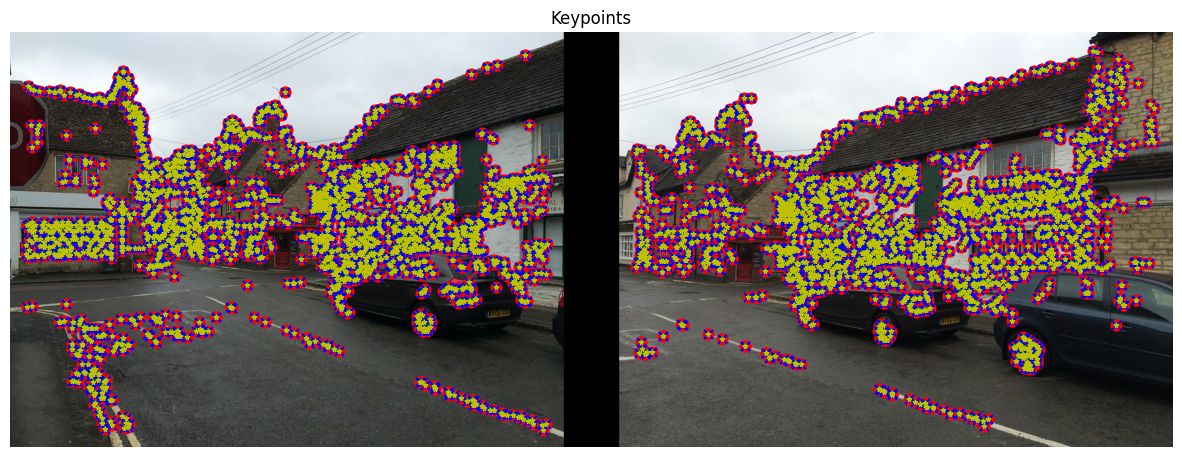

Putative Correspondences: 794


In [6]:
# Image Stitching Script - Part I

# You might want to loop over all image sets, but this takes time
# so you can specify one set at a time
rootpath = ""
to_stitch = 'stitch/eyensham'
I1 = read_img(os.path.join(rootpath,to_stitch,'p1.jpg'))
I2 = read_img(os.path.join(rootpath,to_stitch,'p2.jpg'))

# Step 1: obtain keypoint locations and descriptors for each image separately

# visualize keypoints on at least one of the images
k1, matches_1 = get_AKAZE(I1)
k2, matches_2 = get_AKAZE(I2)
print("Keypoints: {}, {}".format(k1.shape, k2.shape))
visualize_keypoints(I1, I2, k1.copy(), k2.copy())


# Step 2: detect putative correspondences
matches = find_matches(matches_1, matches_2, 0.7)
print("Putative Correspondences: {}".format(len(matches)))

# the above is the slowest step
# continue in new box


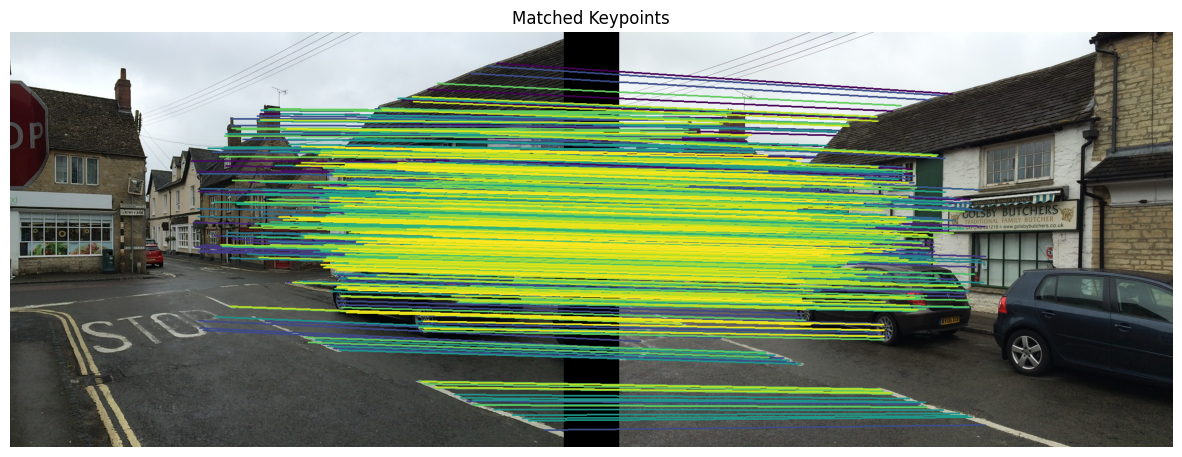

Best Count: 565


In [7]:
# Image Stitching Script - Part II
# Maintain this split. You will thank me later.

# draw matches
matches = np.array(matches)
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Matched Keypoints')
ax.imshow(draw_matches(I1.copy(), I2.copy(), k1.copy(), k2.copy(), matches))
plt.axis('off')
plt.show()

# Step 3: RANSAC for homography fitting
# get pixel values for keypoints
matched_kps = np.hstack([k1[matches[:,0],:2], k2[matches[:,1],:2]])
H = RANSAC_fit_homography(matched_kps)

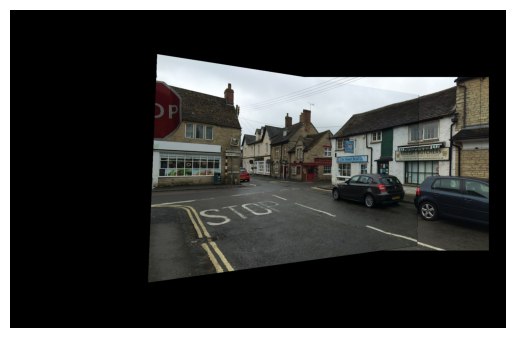

In [8]:
# Step 4: stitching the images
# Be careful about the final image size
# all pixels of warped image must be included
# when both images map to a pixel of the output, picking either one is fine
# (no need to blend)
res = warp_and_combine(I1, I2, H)

plt.imshow(res)
plt.axis('off')
plt.show()